# キャプション生成チュートリアル

- 参考は [こちら](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

<img src="https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png" title="Model" width="60%">

- Image Encoder ... ResNet (CNN)
- Text Decoder ... LSTM



## 準備
- オリジナルの COCO データサイズが大きいため、ここでは動作の確認として、予め作成しておいたミニマルデータを使用します

In [ ]:
%%bash

# wget -nc http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P $DDIR
# wget -nc http://images.cocodataset.org/zips/val2014.zip -P $DDIR
wget -nc "https://drive.google.com/uc?export=download&id=12SIP-geDhh5XHw-6q4UzbYAfXQyS0CN0" -O small_coco.tar.gz

tar -zxvf small_coco.tar.gz \
  && rm -rf small_coco.tar.gz

datasets/
datasets/.ipynb_checkpoints/
datasets/images/
datasets/images/COCO_val2014_000000008647.jpg
datasets/images/COCO_val2014_000000008787.jpg
datasets/images/COCO_val2014_000000008443.jpg
datasets/images/.ipynb_checkpoints/
datasets/images/COCO_val2014_000000008188.jpg
datasets/images/COCO_val2014_000000008010.jpg
datasets/images/COCO_val2014_000000008718.jpg
datasets/images/COCO_val2014_000000008690.jpg
datasets/images/COCO_val2014_000000008351.jpg
datasets/images/COCO_val2014_000000008953.jpg
datasets/images/COCO_val2014_000000008080.jpg
datasets/images/COCO_val2014_000000008196.jpg
datasets/images/COCO_val2014_000000008612.jpg
datasets/images/COCO_val2014_000000008688.jpg
datasets/images/COCO_val2014_000000008532.jpg
datasets/images/COCO_val2014_000000008665.jpg
datasets/images/COCO_val2014_000000008771.jpg
datasets/images/COCO_val2014_000000008401.jpg
datasets/images/COCO_val2014_000000008888.jpg
datasets/images/COCO_val2014_000000008548.jpg
datasets/images/COCO_val2014_00000

--2021-05-24 21:17:43--  https://drive.google.com/uc?export=download&id=12SIP-geDhh5XHw-6q4UzbYAfXQyS0CN0
Resolving drive.google.com (drive.google.com)... 108.177.126.102, 108.177.126.139, 108.177.126.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ldosg0kkds54j5od23a3rnro12i8al1j/1621891050000/07139579360538472045/*/12SIP-geDhh5XHw-6q4UzbYAfXQyS0CN0?e=download [following]
--2021-05-24 21:17:44--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ldosg0kkds54j5od23a3rnro12i8al1j/1621891050000/07139579360538472045/*/12SIP-geDhh5XHw-6q4UzbYAfXQyS0CN0?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-10-4c-docs.googleusercontent.com (d

In [ ]:
%%bash

cat << END > requirements.txt
fugashi==1.1.0
ipadic==1.0.0
pycocotools==2.0.2
seaborn==0.11.1
transformers==4.6.1
omegaconf==2.0.6
END

pip install -r requirements.txt

  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import sys
import json
import logging
import random
import requests
from glob import glob
from typing import List, Dict
from pprint import pformat, pprint
from collections import Counter, defaultdict

from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


logging.basicConfig(
    format='%(asctime)s #%(lineno)s %(levelname)s %(name)s :::  %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
    stream=sys.stdout,
)
logger = logging.getLogger(__name__)


RED = '\033[31m'
GREEN = '\033[32m'
YELLOW = '\033[33m'
BLUE = '\033[34m'
END = '\033[0m'

## トークナイザ
- transformers の Tokenizer を使用します
  - [BertJapaneseTokenizer](https://huggingface.co/transformers/model_doc/bert_japanese.html#bertjapanesetokenizer)
  - [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, BertJapaneseTokenizer


class MyTokenizer(object):
    def __init__(self, model='cl-tohoku/bert-base-japanese-whole-word-masking', max_len=256):
        self.name = model
        self.max_length = max_len

    @property
    def tokenizer(self):
        if 'japanese' in self.name:
            from transformers import BertJapaneseTokenizer
            return BertJapaneseTokenizer.from_pretrained(self.name)
        elif 'bert' in self.name:
            from transformers import BertTokenizer
            return BertTokenizer.from_pretrained(self.name)
        # else:

    def tokenize(self, sentence:str):
        return self.tokenizer(
            sentence,
            max_length = self.max_length,
            truncation = True,
            padding = True,
            return_tensors = "pt",
        )

    def decode(self, input_ids:torch.tensor):
        return self.tokenizer.decode(input_ids)


if __name__ == '__main__':
    tokenizer = MyTokenizer()
    inputs = tokenizer.tokenize('今日はいい天気ですね')
    pprint(inputs)
    print(tokenizer.decode(inputs['input_ids'][0]))

    tokenizer = MyTokenizer(model='bert-base-uncased')
    inputs = tokenizer.tokenize('Time flies like an arrow.')
    pprint(inputs)
    print(tokenizer.decode(inputs['input_ids'][0]))

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[    2,  3246,     9,  2575, 11385,  2992,  1852,     3]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]])}
[CLS] 今日 は いい 天気 です ね [SEP]
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  2051, 10029,  2066,  2019,  8612,  1012,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]])}
[CLS] time flies like an arrow. [SEP]


## データ

- Transforms
  - https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor
  - [transforms](https://pystyle.info/pytorch-list-of-transforms/#outline__5_6) についてはこちらが分かりやすい

- 使用するデータセット
  - 画像 ... [MS-COCO 2014](https://cocodataset.org/#download)
    - https://pytorch.org/vision/stable/datasets.html#coco
  - キャプション
    - 日本語 ... [STAIR Captions](https://github.com/STAIR-Lab-CIT/STAIR-captions) (MS-COCO 2014 に対して日本語でアノテーション)
    - 英語 ... MS-COCO 2014 で提供されているキャプション

### Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import CocoCaptions

class MyDataset(Dataset):
    def __init__(self, caption='stair'):
        self.dataset = CocoCaptions(
            root = 'datasets/images',
            annFile = f'datasets/captions/{caption}_small.json',
            transform = self.transform_fn,
            target_transform = lambda x: random.choice(x),
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, caption = self.dataset[idx]
        return image, caption

    @property
    def transform_fn(self):  # 入力画像の処理
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((.485, .456, .406), (.229, .224, .225))
        ])


if __name__ == '__main__':
    dataset = MyDataset(caption='stair')
    image, caption = dataset[0]
    print('| caption ... ', caption)
    print('| image size ... ', image.size())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
| caption ...  水色の機体の飛行機が停まっている
| image size ...  torch.Size([3, 224, 224])


### DataLoader
- ミニバッチごとに dataset からデータを取り出すための `__iter__` メソッドを保持

In [ ]:
import torch
from torch.utils.data import DataLoader

class MyLoader(DataLoader):
    def __init__(self, dataset, tokenizer, **kwargs):
        super().__init__(dataset, **kwargs)
        self.tokenizer = tokenizer
        self.collate_fn = self._collate_fn
    
    def _collate_fn(self, batch):
            batch.sort(key=lambda x: len(x[1]), reverse=True)        # キャプションの系列長でソート
            images, captions = zip(*batch)
            images = torch.stack(images, 0)                          # 画像
            captions = self.tokenizer.tokenize(captions)['input_ids']
            lengths = [len(cap) for cap in captions]                  # キャプションの系列長 
            targets = torch.zeros(len(captions), max(lengths)).long() # キャプション 
            for i, cap in enumerate(captions):
                end = lengths[i]
                targets[i, :end] = cap[:end]
            return images, targets, lengths


if __name__ == '__main__':
    dataloader = MyLoader(
        dataset = MyDataset(caption='stair'),
        tokenizer = MyTokenizer(model='cl-tohoku/bert-base-japanese-whole-word-masking'),
        batch_size = 4,
        shuffle = True,
    )

    for batch in dataloader:
        images, targets, lengths = batch
        print(images.size(), targets.size(), lengths)
        break

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
torch.Size([4, 3, 224, 224]) torch.Size([4, 16]) [16, 16, 16, 16]


## モデル

### Image Encoder
- ResNet (CNN-based) を使用

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ImageEncoder(nn.Module):
    def __init__(self, dim_eh=512):
        super().__init__()
        resnet = models.resnet152(pretrained=True)            # ResNet-152 のロード
        dim_i = resnet.fc.in_features
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # 最終FC層を削除
        self.linear = nn.Linear(dim_i, dim_eh)
        self.bn = nn.BatchNorm1d(dim_eh, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

### Text Decoder
- TextEncoder に [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) を使用する

In [ ]:
from transformers import BertModel

class TextEncoder(nn.Module):
    def __init__(self, dim_eh=512, model='cl-tohoku/bert-base-japanese-v2'):
        super().__init__()
        self.name = model
        self.model = BertModel.from_pretrained(self.name)
        self.linear = nn.Linear(self.model.pooler.dense.out_features, dim_eh)
        self.vocab_size = self.model.config.vocab_size
        for param in self.model.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids):
        outputs = self.model(input_ids=input_ids)
        return self.linear(outputs.last_hidden_state)
        # return self.linear(outputs.pooler_output)


if __name__ == '__main__':
    encoder = TextEncoder()
    tokenizer = MyTokenizer()

    inputs = tokenizer.tokenize('我輩は猫である')
    outputs = encoder(inputs['input_ids'])

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence

class TextDecoder(nn.Module):
    def __init__(self, dim_eh=512, dim_dh=512, num_layers=2, max_seq_length=256, bert_cfg='cl-tohoku/bert-base-japanese-v2'):
        super().__init__()
        # self.txt_enc = TextEncoder(dim_eh=dim_eh, model=bert_cfg)
        # self.embed = nn.Embedding(self.txt_enc.vocab_size, dim_eh)
        self.lstm = nn.LSTM(dim_eh, dim_dh, num_layers, batch_first=True)
        self.linear = nn.Linear(dim_dh, self.txt_enc.vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        # embeddings = self.embed(captions)
        embeddings = self.txt_enc(input_ids=captions)           # なくて良いのでは？ という気持ち
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):  # 推論時（greedy）
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))     # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # ボキャブラリから最大スコアのトークンを一つ選択
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)               # 予測したトークンを再度 LSTM へ入力するための処理
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## 訓練

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ロス関数
criterion = nn.CrossEntropyLoss()

# 最適化
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

# トークナイザ
tokenizer = Tokenizer(model='cl-tohoku/bert-base-japanese-whole-word-masking', max_len=256)

# データ
dataset = MyDataset(caption='stair')
train_loader = MyLoader(
    dataset = dataset,
    tokenizer = tokenizer,
    batch_size = 32,
    shuffle = True,
)

# モデル
encoder = ImageEncoder(dim_eh=512)
decoder = TextDecoder(dim_eh=512, dim_dh=512)
encoder.to(DEVICE)
decoder.to(DEVICE)

print()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Main
- NOTE: うまく学習するためのデータ数がないため、あくまで動作確認

In [ ]:
dir_model = 'models'
os.makedirs(dir_model, exist_ok=True)

for ep in range(2):
    for i, (images, captions, lengths) in enumerate(train_loader):
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        assert outputs.size()[0] == targets.size()[0]
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            logger.info(f'Ep.[{ep}] - {i}: Loss={round(loss.item(), 4)}, Perplexity: {round(np.exp(loss.item()), 4)}')
            
        # Save the model checkpoints
        if (i+1) % 500 == 0:
            torch.save(decoder.state_dict(), os.path.join(dir_model, f'decoder.ckpt'))
            torch.save(encoder.state_dict(), os.path.join(dir_model, f'encoder.ckpt'))
            logger.info(GREEN + f'| WRITE ... {dir_model}/**coder.ckpt' + END)

2021-05-25 01:33:58 #20 INFO __main__ :::  Ep.[0] - 0: Loss=10.3779, Perplexity: 32139.8037
2021-05-25 01:34:03 #20 INFO __main__ :::  Ep.[1] - 0: Loss=10.3847, Perplexity: 32359.7992


# 実際に日本語のキャプション生成を行ってみる
- 以前作成したキャプション生成モデルをロード
  - https://github.com/smiyawaki0820/ImageCaptionning
- 本セクションから開始してもエラーは起きない（多分）

In [ ]:
%%bash

curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=1rMeZUo1keti2LwOkj-9tzqQhbPbtHmX4" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"  

echo $CODE

6Sn9


In [ ]:
%%bash

# モデルのロード
rm -rf models
mkdir -p models

curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=1rMeZUo1keti2LwOkj-9tzqQhbPbtHmX4" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"
curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=1rMeZUo1keti2LwOkj-9tzqQhbPbtHmX4" -o models/encoder.ckpt

curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=1Hbcs6xyfwhbYpyvdKZRHgh9qC0D7KT_R" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"
curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=1Hbcs6xyfwhbYpyvdKZRHgh9qC0D7KT_R" -o models/decoder.ckpt

du -h models


# 実験設定のファイル
wget -nc "https://drive.google.com/uc?export=download&id=1CGH7hMf9TjZxT6X3hkIexQnp3NLO5c85" -O config.yml

# 環境
cat << END > requirements.txt
fugashi==1.1.0
ipadic==1.0.0
pycocotools==2.0.2
seaborn==0.11.1
transformers==4.6.1
omegaconf==2.0.6
END

pip install -r requirements.txt

254M	models


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3743      0 --:--:-- --:--:-- --:--:--  3709
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 82.3M    0 82.3M    0     0  98.9M      0 --:--:-- --:--:-- --:--:-- 98.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2684      0 --:--:-- --:--:-- --:--:--  2666
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  171M    0  171M    0     0   102M      0 --:--:--  0:00:01 --:--:--  243M
File ‘config.yml’ already there; not retrieving.


In [ ]:
import os
import requests
from typing import List, Dict

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms


RED = '\033[31m'
GREEN = '\033[32m'
YELLOW = '\033[33m'
BLUE = '\033[34m'
END = '\033[0m'


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, BertJapaneseTokenizer


class MyTokenizer(object):
    def __init__(self, model='cl-tohoku/bert-base-japanese-whole-word-masking', max_len=256):
        self.name = model
        self.max_length = max_len

    @property
    def tokenizer(self):
        if 'japanese' in self.name:
            from transformers import BertJapaneseTokenizer
            return BertJapaneseTokenizer.from_pretrained(self.name)
        elif 'bert' in self.name:
            from transformers import BertTokenizer
            return BertTokenizer.from_pretrained(self.name)
        # else:

    def tokenize(self, sentence:str):
        return self.tokenizer(
            sentence,
            max_length = self.max_length,
            truncation = True,
            padding = True,
            return_tensors = "pt",
        )

    def decode(self, input_ids:torch.tensor):
        return self.tokenizer.decode(input_ids)

## モデル
- 上記のチュートリアルのモデルと若干異なるので再定義します

In [ ]:
from omegaconf.dictconfig import DictConfig
from transformers import DeiTFeatureExtractor, DeiTModel, DeiTConfig

class ImageEncoder(nn.Module):
    def __init__(self, cfg:DictConfig) -> None:
        super().__init__()
        self.model_name = cfg.model.enc_image.model_name
        self.base, dim_i, dim_e = self.set_model()
        for p in self.base.parameters():
            p.requires_grad = False
        self.linear = nn.Linear(dim_e, cfg.model.enc_image.dim_out)
        self.bnorm = nn.BatchNorm1d(dim_e, momentum=cfg.model.enc_image.batch_norm)
        self.resize = transforms.Resize((dim_i, dim_i))

    def set_model(self):
        if self.model_name == 'resnet34':
            base = models.resnet34(pretrained=True)
            dim_e = base.fc.in_features
            base.fc = nn.Identity() # 最後のfc層は不要
            return base, 128, dim_e
        elif self.model_name == 'deit':
            # self.feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224', crop_size=128)
            base = DeiTModel.from_pretrained('facebook/deit-base-distilled-patch16-224', add_pooling_layer=True)
            dim_e = base.pooler.dense.out_features
            return base, 224, dim_e

    def forward(self, x):   # batch * channel * height * width
        x = self.resize(x)
        x = self.base(x)
        if self.model_name in ('deit'):
            x = x['pooler_output']
        return self.bnorm(self.linear(x))


class TextDecoder(nn.Module):
    def __init__(self, cfg:DictConfig, vocab_size:int):
        super().__init__()
        dim_i = cfg.model.enc_image.dim_out
        self.embed = nn.Embedding(vocab_size, dim_i)
        self.lstm = nn.LSTM(dim_i, cfg.model.dec_text.dim_out)
        self.linear = nn.Linear(cfg.model.dec_text.dim_out, vocab_size)
        self.seq_len = cfg.model.dec_text.seq_len

    def forward(self, x, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((x.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.seq_len):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
from omegaconf import OmegaConf
from omegaconf.dictconfig import DictConfig


cfg = OmegaConf.load('config.yml')

transform_fn =  transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.485, .456, .406), std=(.229, .224, .225)),
])

tokenizer = MyTokenizer(cfg.model.tokenizer.model_name)
encoder = ImageEncoder(cfg).to(DEVICE)
decoder = TextDecoder(cfg, 32000).to(DEVICE)

encoder.eval()
decoder.eval()

# 訓練済みのモデルパラメータをロード
dir_model = '/content/models/'
encoder.load_state_dict(torch.load(os.path.join(dir_model, 'encoder.ckpt')))
decoder.load_state_dict(torch.load(os.path.join(dir_model, 'decoder.ckpt')))

<All keys matched successfully>

## Main

画像を入力してください > https://instagrammernewsimg.s3.ap-northeast-1-ntt.wasabisys.com/CJYvfxoBgwZ
犬が舌を出してこちらを見ている


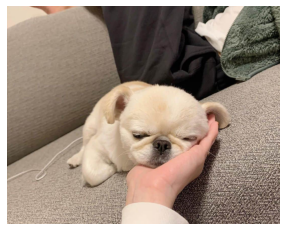

In [ ]:
path = input('画像を入力してください > ')
if os.path.isfile(path):
    image = Image.open(path)
elif path.startswith('http'):
    image = Image.open(requests.get(path, stream=True).raw)

image_tensor = transform_fn(image).to(DEVICE)
image_tensor = torch.stack([image_tensor])

# 画像から トークンID を生成
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# トークンID のデコード
sentence = tokenizer.tokenizer.decode(sampled_ids)
sentence = sentence.replace('[CLS]', '').replace('[SEP]', '').replace('[PAD]', '')
sentence = ''.join(sentence.split())

# 出力画像の表示
print(sentence, flush=True)
plt.imshow(image)
plt.axis('off')
plt.show()